# File: Ensemble Version 1 (Basic) with 200k data

This will be the first working notebook on an Ensemble Run.

Here we will take the results of 6 runs: 3 Surprise Collab Filters and 3 Regression Content Filters. Their results from predictions (on the vali set) should all be saved to file. Here are the runs/files we'll use from the subrun folder:

Collabrative Filter Runs (from different techniques)
* A3_073_surprise_svdpp_subrun
* A3_074_surprise_knnmeans_subrun
* A3_076_surprise_baseline_subrun
Content Filter Runs
* A3_062_lgbm_regression_beercontext_subrun
* A3_063_lgbm_regression_consumercontext_subrun
* A3_080_sk_linreg1_subrun

All the files will be loaded and all the predicted ratings will be loaded into a single dataframe. 
Then, the dataframe will be fed into a LightGBM Regressor and the model fitted. Then, predict on the validation dataframe, and compare the results to see what our MAE is.


In [6]:
# Import libraries
import pandas as pd
import numpy as np
import lightgbm as lgb

from sklearn.metrics import mean_absolute_error

from utilities import data_basic_utility as databasic
from utilities import dataframe_utility as dfutil
import features_utility as featutil

In [7]:
filePrefix = "A3_090_ensemble_v1_200k"
baseDataDir = "C:/Development/Data/COSC2670/Assignment3/A3data/"
subrunDir = "subruns/"
runDir = "runs/"
seed = databasic.get_random_seed()

In [ ]:
trainFilePath = baseDataDir + 'train_200k.tsv'
valiFilePath = baseDataDir + 'vali_200k.tsv'
featuresFilePath = baseDataDir + 'features_200k.tsv'
testFilePath = baseDataDir + 'test_200k.tsv'

In [8]:
# Load the Validation file

df_vali = pd.read_csv(valiFilePath,sep='\t',
                         names=['RowID','BeerID','ReviewerID',
                                  'BeerName','BeerType','rating'])
df_vali.head(10)

,RowID,BeerID,ReviewerID,BeerName,BeerType,rating
0,22,12300,2634,Rauch �r Bock,Rauchbier,4.0
1,27,12300,5634,Rauch �r Bock,Rauchbier,4.5
2,28,12300,3544,Rauch �r Bock,Rauchbier,4.5
3,40,12300,6521,Rauch �r Bock,Rauchbier,4.0
4,43,12300,10177,Rauch �r Bock,Rauchbier,4.5
5,48,12300,2907,Rauch �r Bock,Rauchbier,3.5
6,49,12300,1532,Rauch �r Bock,Rauchbier,4.0
7,50,12300,3452,Rauch �r Bock,Rauchbier,3.5
8,59,12300,6861,Rauch �r Bock,Rauchbier,4.0
9,64,6699,6401,Caldera Pale Ale,American Pale Ale (APA),4.5


In [9]:
# For the full data to use for training and then validation, just get the Row ID and rating.
df_ensemble_full = df_vali[["RowID", "rating"]]

In [10]:
# Collaborative Filter Runs
df_ensemble_full = featutil.joinRunToEnsembleFrame(df_ensemble_full, subrunDir, "A3_072_surprise_svdpp_subrun")
df_ensemble_full = featutil.joinRunToEnsembleFrame(df_ensemble_full, subrunDir, "A3_074_surprise_knnmeans_subrun")
df_ensemble_full = featutil.joinRunToEnsembleFrame(df_ensemble_full, subrunDir, "A3_076_surprise_baselineonly_subrun")

# Content Filter Runs
df_ensemble_full = featutil.joinRunToEnsembleFrame(df_ensemble_full, subrunDir, "A3_062_lgbm_regression_beercontext_subrun")
df_ensemble_full = featutil.joinRunToEnsembleFrame(df_ensemble_full, subrunDir, "A3_063_lgbm_regression_consumercontext_subrun")
df_ensemble_full = featutil.joinRunToEnsembleFrame(df_ensemble_full, subrunDir, "A3_080_sk_linreg1_subrun")

df_ensemble_full.head(10)


,RowID,rating,A3_072_surprise_svdpp_subrun,A3_074_surprise_knnmeans_subrun,A3_076_surprise_baselineonly_subrun,A3_062_lgbm_regression_beercontext_subrun,A3_063_lgbm_regression_consumercontext_subrun,A3_080_sk_linreg1_subrun
0,22,4.0,4.307723,4.411133,4.265737,4.0,4.0,3.903601
1,27,4.5,4.200102,4.246060,4.202083,4.0,4.0,3.905488
2,28,4.5,4.335563,4.432695,4.371105,4.0,4.0,3.916742
3,40,4.0,4.217186,4.259541,4.231804,4.0,4.0,3.917982
4,43,4.5,4.162843,4.100380,4.176680,4.0,4.0,3.922350
5,48,3.5,3.940503,4.064850,3.993235,4.0,4.0,3.916427
6,49,4.0,4.225543,4.285378,4.236586,4.0,4.0,3.915981
7,50,3.5,4.080092,4.123385,4.116234,4.0,4.0,3.917165
8,59,4.0,4.258105,4.372299,4.294158,4.0,4.0,3.906602
9,64,4.5,3.991560,4.061589,4.003137,4.0,4.0,3.871152


In [11]:
# Get all the columns
col_names = df_ensemble_full.columns

idCols = ['RowID']
feature_cols =  col_names.drop(['RowID','rating' ])
target_col = 'rating'

# Create the sub data sets of the features and the target
dfTrainIds = df_ensemble_full[idCols]
dfTrainFeatures = df_ensemble_full[feature_cols]
dfTrainTarget = df_ensemble_full[target_col]


In [12]:
print(dfTrainFeatures.shape)
dfTrainFeatures.head()

(36385, 6)


,A3_072_surprise_svdpp_subrun,A3_074_surprise_knnmeans_subrun,A3_076_surprise_baselineonly_subrun,A3_062_lgbm_regression_beercontext_subrun,A3_063_lgbm_regression_consumercontext_subrun,A3_080_sk_linreg1_subrun
0,4.307723,4.411133,4.265737,4.0,4.0,3.903601
1,4.200102,4.246060,4.202083,4.0,4.0,3.905488
2,4.335563,4.432695,4.371105,4.0,4.0,3.916742
3,4.217186,4.259541,4.231804,4.0,4.0,3.917982
4,4.162843,4.100380,4.176680,4.0,4.0,3.922350


In [13]:
# Doing the final Ensemble prediction using Light GBM Regression
# Best Params 1 (overfitting?):
# {'learning_rate': 0.2997889115498367, 'num_leaves': 256, 'max_depth': 25, 'n_estimators ': 968}
# Best Params 2 (num leaves restricted to 127 to protect against overfitting)
# {'learning_rate': 0.298864877137463, 'num_leaves': 127, 'max_depth': 26, 'n_estimators ': 974}

# Untuned
# model = lgb.LGBMRegressor(objective="regression_l1", metric="mae", random_state=seed)

model = lgb.LGBMRegressor(objective="regression_l1", metric="mae", random_state=seed,
  learning_rate=0.298864877137463, num_leaves=127, max_depth=26, n_estimators=974
)
model.fit(X=dfTrainFeatures, y=dfTrainTarget)

LGBMRegressor(learning_rate=0.298864877137463, max_depth=26, metric='mae',
              n_estimators=974, num_leaves=127, objective='regression_l1',
              random_state=63521)

In [14]:
# Now use the model to predict the rating
test_predicted = model.predict(dfTrainFeatures)
test_predicted[0:100]

array([3.99496114, 4.50070537, 4.44925859, 4.03629817, 4.50177568,
       3.74185414, 4.26670395, 3.94634515, 4.35420889, 4.08758091,
       4.33237727, 3.98679299, 4.12105869, 4.31719604, 3.99056173,
       4.06624784, 3.94458165, 4.04972698, 4.02357477, 4.00741691,
       4.08665445, 3.9840766 , 4.02394378, 3.85215214, 4.02142544,
       4.06447008, 4.00470659, 3.92318136, 3.61903182, 4.06142802,
       4.01039025, 3.71174468, 4.00183341, 3.84934785, 3.99328353,
       3.89840301, 4.08933737, 4.07243297, 3.62150913, 3.79917547,
       4.47626808, 3.84798328, 3.93431769, 3.99479545, 3.50831023,
       3.8452522 , 3.42193778, 3.68372008, 3.79050463, 3.55422989,
       3.52488611, 3.99699711, 4.38523354, 3.38358131, 4.11399785,
       4.17358105, 3.41225377, 4.01820554, 4.07787251, 3.98931605,
       4.00434007, 4.00198157, 4.07601648, 4.01082009, 3.78639153,
       4.02660721, 4.35222935, 4.00019991, 4.00990009, 3.99835546,
       4.42143954, 4.4762962 , 4.45232201, 3.92182871, 3.99088

<AxesSubplot:>

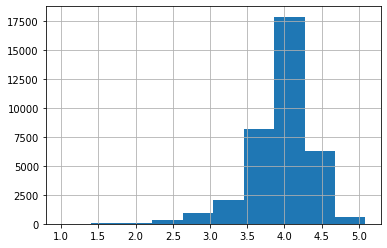

In [15]:
dfPredicted = pd.DataFrame({"Predict": test_predicted})
dfPredicted['Predict'].hist(bins=10)

In [16]:
mae = mean_absolute_error(dfTrainTarget, test_predicted)

print("Ensemble Final Average MAE: " + str(mae))
print("analyse_maes.append(" + str(mae) + ")")

Ensemble Final Average MAE: 0.2810226063295058
analyse_maes.append(0.2810226063295058)


In [17]:
dfPredicted = pd.concat([dfTrainIds.reset_index(), dfPredicted], axis=1).drop(columns="index")

dfPredicted.to_csv(runDir + filePrefix + "_run.csv", index=False)

print("Ensemble Final Average MAE: " + str(mae))
print(dfPredicted.shape)
dfPredicted.sort_values("RowID").head(20)


Ensemble Final Average MAE: 0.2810226063295058
(36385, 2)


,RowID,Predict
0,22,3.994961
1,27,4.500705
2,28,4.449259
3,40,4.036298
4,43,4.501776
5,48,3.741854
6,49,4.266704
7,50,3.946345
8,59,4.354209
9,64,4.087581


In [18]:
print(model.best_iteration_)
print(model.best_score_)
print(model.feature_importances_)

None
defaultdict(<class 'collections.OrderedDict'>, {})
[28191 30022 26790  5386     0 32335]


## Final Results:
* No Tuning
* Ensemble Final Average MAE: 0.4031750456475777

Best Params (large num leaves, possible overfitting)
* {'learning_rate': 0.2997889115498367, 'num_leaves': 256, 'max_depth': 25, 'n_estimators ': 968}
* Ensemble Final Average MAE:  0.24045789955427213

Best Params 2 (num leaves restricted to 127 to protect against overfitting)
* {'learning_rate': 0.298864877137463, 'num_leaves': 127, 'max_depth': 26, 'n_estimators ': 974}
* Ensemble Final Average MAE: 0.2810226063295058

### MAE of parts, for comparison
* A3_073_surprise_svdpp_subrun: 0.4283718397372383
* A3_074_surprise_knnmeans_subrun: 0.4377105335852574
* A3_076_surprise_baseline_subrun: 0.4262243789863012
* A3_062_lgbm_regression_beercontext_subrun: 0.4528618728423355
* A3_063_lgbm_regression_consumercontext_subrun: 0.4599019635783294
* A3_080_sk_linreg1_subrun: 0.466425736378539